# Removing bias enables generalization

In this notebook, we look at the generalization comparisons between a given model (e.g. DnCNN), and its bias free  version (e.g. BF_DnCNN). 

Inside the training range, the two models show comparable performance. However, outside the training range, bias free network, outperforms the other network significantly. 

In this notebook, we look at

1. comparative performance of the models on single images. 

2. comparative performance of the models averaged across many images. 

3. behavior of net bias inside and outside the training range




In [2]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from skimage.measure.simple_metrics import compare_psnr, compare_mse

import sys  
sys.path.insert(0, '../code')
from utils_train import *
from DnCNN import *

%matplotlib inline

### Load both trained models: 1) model with net bias, 2) model without net bias

In [3]:
all_params = {
'epochs': 50,
"learning_rate" : .001,
'parent_included': 'not applicable',
'kernel_size_waves': 'not applicable',

"kernel_size_mid" : 3,
"padding_mid" : 1,
"num_mid_kernels" : 64,
"num_mid_layers" : 20,

"batch_size" : 128,
"patch_size" : (50,50),
"patching_strides" : (10,10),
'scales' : [1,.9,.8,.7],
}

# select the noise range models have been trained on. Look in models folder to see options.  
l = 0  # lower bound of training range 
h = 10 # higher bound of training range

## model with bias: DnCNN
DnCNN = nn.DataParallel(dncnn(all_params))
DnCNN.load_state_dict(torch.load('../models/DnCNN/range_'+str(l)+'_'+str(h)+'/model.pt',map_location='cpu' ))    
DnCNN.eval();


In [13]:
import models
BF_DnCNN = models.dncnn.DnCNN()
BF_DnCNN.load_state_dict(torch.load('./pretrained/BF_DnCNN/range_0_10.pt'))
BF_DnCNN.eval()

DnCNN(
  (first_layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (hidden_layer_list): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [7]:
# Datasets available in the data folder
train_folder_path = '../data/Train400/'
test_folder_path = '../data/Test/Set68/'
set12_path = '../data/Test/Set12/'
kodak_path = '../data/Test/Kodak23/' 


### Show 4 random noisy images used during training for this model 


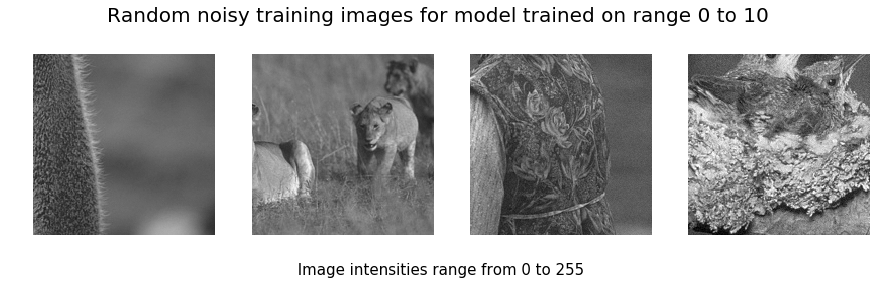

In [8]:
f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)
f.suptitle('Random noisy training images for model trained on range ' + str(l) +' to '+ str(h),  fontname= 'Times New Roman', fontsize = 20)
f.text(.5, .05, ' Image intensities range from 0 to 255',ha='center',  fontname= 'Times New Roman', fontsize = 15)
for i in range(4): 
    tr_im_n = np.random.randint(0,len(os.listdir(train_folder_path)))
    tr_im = single_image_loader(train_folder_path, tr_im_n)
    tr_dim1, tr_dim2 = tr_im.shape
    tr_noisy, _ = add_noise(tr_im.reshape(1,tr_dim1,tr_dim2), [0,10], 'B') 
    tr_noisy = tr_noisy.reshape(tr_dim1,tr_dim2)
    axs[i].imshow(tr_noisy, 'gray', vmin= 0, vmax = 1)
    axs[i].axis('off');
    

## 1. Comparing performance on a single image 

In [14]:
# choose the image number from the dataset 
image_num = 6

clean_im = single_image_loader(set12_path, image_num)
dim1, dim2 = clean_im.shape

# choose noise level  
noise_level = 90 # relative to image intenstities in range (0,255)


noisy_im, noise = add_noise(clean_im.reshape(1,dim1,dim2), noise_level, 'S') 

inp_test = Variable(torch.FloatTensor(noisy_im).unsqueeze(1), volatile = True,requires_grad=False)

residual_dncnn= DnCNN(inp_test).data.squeeze(0).squeeze(0).numpy()
residual_bf_dncnn= BF_DnCNN(inp_test).data.squeeze(0).squeeze(0).numpy()


/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be r

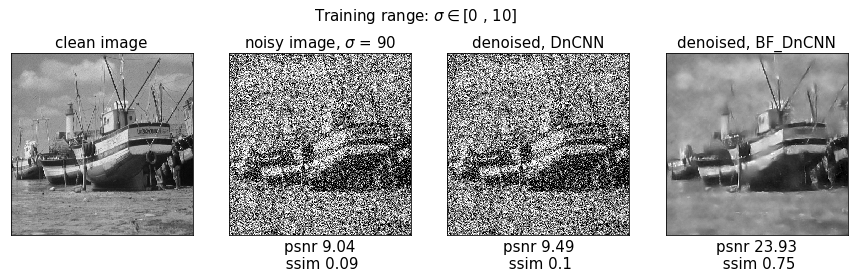

In [15]:
noisy_im = noisy_im.reshape(dim1,dim2)
denoised_dncnn = noisy_im - residual_dncnn.reshape(dim1,dim2)
denoised_bf_dncnn =  residual_bf_dncnn.reshape(dim1,dim2)

f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)

f.suptitle(r'Training range: $\sigma \in [ $' + str(l) +' , '+ str(h) + ']',  fontname= 'Times New Roman', fontsize = 15)

axs[0].imshow(clean_im, 'gray', vmin= 0, vmax = 1)
axs[0].set_title('clean image', fontname= 'Times New Roman', fontsize = 15)

axs[1].imshow(noisy_im, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, noisy_im),2)
ssim = np.round(compare_ssim(clean_im, noisy_im),2)
axs[1].set_title(r'noisy image, $\sigma$ = '+str(noise_level), fontname= 'Times New Roman', fontsize = 15)
axs[1].set_xlabel('psnr ' +str(psnr) + '\n ssim '+str(ssim), fontname= 'Times New Roman', fontsize = 15)

axs[2].imshow(denoised_dncnn, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, denoised_dncnn),2)
ssim = np.round(compare_ssim(clean_im, denoised_dncnn),2)
axs[2].set_title('denoised, DnCNN', fontname= 'Times New Roman', fontsize = 15)
axs[2].set_xlabel('psnr ' +str(psnr)+'\n ssim '+str(ssim), fontname= 'Times New Roman', fontsize = 15)

axs[3].imshow(denoised_bf_dncnn, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, denoised_bf_dncnn),2)
ssim = np.round(compare_ssim(clean_im, denoised_bf_dncnn),2)
axs[3].set_title('denoised, BF_DnCNN', fontname= 'Times New Roman', fontsize = 15)
axs[3].set_xlabel('psnr ' +str(psnr)+'\n ssim '+str(ssim), fontname= 'Times New Roman', fontsize = 15)

for i in range(4): 
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)



## 2. Comparing performance across many images

The following plot shows output PSNR against input PSNR for DnCNN vs. BFCNN.

In order to calculate PSNR on set 68 using another model, run psnr68_calculator.py. The results will be saved in the model's results folder. 


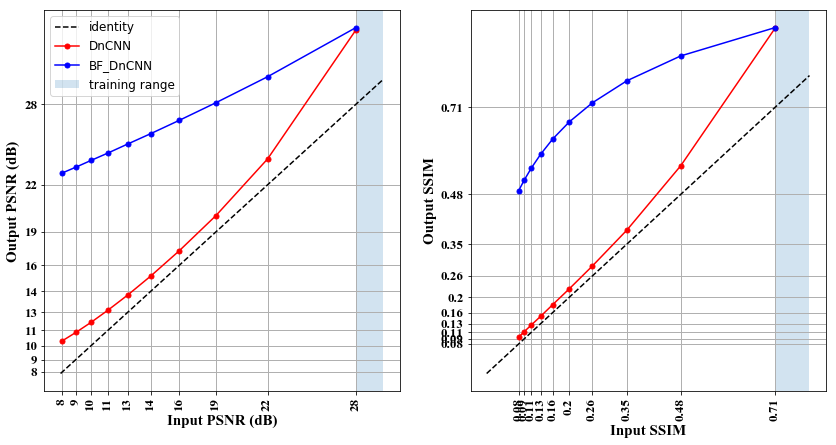

In [15]:
f , axs = plt.subplots(1,2, figsize=(14,7))

l = 0
h = 10

#### PSNR
dncnn_psnr68 = np.load('models/DnCNN/range_'+str(l)+'_'+str(h)+'/results/psnr68_list.npy')
bf_dncnn_psnr68 = np.load('models/BF_DnCNN/range_'+str(l)+'_'+str(h)+'/results/psnr68_list.npy')
x_axis = [ -10*np.log10( (s/255)**2  ) for s in range(10,110,10)]
axs[0].plot( [8,30],[8,30] ,'k--', alpha = 1, label = 'identity');
axs[0].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
axs[0].set_yticklabels(np.round(x_axis).astype(int) , fontsize=13, fontname= 'Times New Roman');
axs[0].set_xlabel('Input PSNR (dB)', fontsize=15, fontname= 'Times New Roman')
axs[0].set_ylabel('Output PSNR (dB)', fontsize=15, fontname= 'Times New Roman')        
axs[0].plot(x_axis, dncnn_psnr68[1::], color = 'red', marker = '.',markersize = 10, label = 'DnCNN')
axs[0].plot(x_axis, bf_dncnn_psnr68[1::], color = 'blue', marker = '.',markersize = 10, label = 'BF_DnCNN')
axs[0].set_xticks(x_axis)
axs[0].set_yticks(x_axis)
axs[0].grid(linewidth=1)
if l != 0:
    axs[0].axvspan(-10*np.log10( (h/255)**2) , -10*np.log10( (l/255)**2)  , alpha=0.2, label='training range');        
else: 
    axs[0].axvspan(-10*np.log10( (h/255)**2) , 30  , alpha=0.2, label='training range');
axs[0].legend(fontsize = 12);

#### SSIM 
dncnn_ssim68 = np.load('models/DnCNN/range_'+str(l)+'_'+str(h)+'/results/ssim68_list.npy')
bf_dncnn_ssim68 = np.load('models/BF_DnCNN/range_'+str(l)+'_'+str(h)+'/results/ssim68_list.npy')
x_axis = np.load('models/DnCNN/range_'+str(l)+'_'+str(h)+'/results/ssim68_input.npy')
axs[1].plot( [0,.8],[0,.8] ,'k--', alpha = 1, label = 'identity');
axs[1].set_xticklabels(np.round(x_axis,2) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
axs[1].set_yticklabels(np.round(x_axis,2) , fontsize=13, fontname= 'Times New Roman');
axs[1].set_xlabel('Input SSIM', fontsize=15, fontname= 'Times New Roman')
axs[1].set_ylabel('Output SSIM', fontsize=15, fontname= 'Times New Roman')
axs[1].plot(x_axis, dncnn_ssim68[1::], color = 'red', marker = '.',markersize = 10, label = 'DnCNN')
axs[1].plot(x_axis, bf_dncnn_ssim68[1::], color = 'blue', marker = '.',markersize = 10, label = 'BF_DnCNN')
axs[1].set_xticks(x_axis)
axs[1].set_yticks(x_axis)
if l != 0:
    axs[1].axvspan( x_axis[int(h/10)-1] ,x_axis[int(l/10)-1], alpha=0.2, label='training range');        
else: 
    axs[1].axvspan( x_axis[int(h/10)-1] ,.8 , alpha=0.2, label='training range');
axs[1].grid(linewidth=1)


## 3. Network bias impairs generalization 

A regular network with ReLU nonlinearities can be thought of as a cascade of affine transformations. For such network, we can break down the total transformation to two components: linear part, and the net bias. We observed that the net bias is always pushed to zero inside the training range. However outside the training range, it explodes. This coincides with the significant denoising performance drop, reflected in divergence of residual from the identity line. By removing the bias from the network we push it to be zero even outside the training range. This results in a surprisingly dramatic boost in performance, which is reflected in residual estimating the noise much better (i.e. residual is close to identity).

The following plots show the norms of the residual and the net bias averaged over 100 $20 \times 20$ natural-image patches. 
 
 
In order to try this results on another network, run bias_linear_decomp.py module, available in code folder. The averaged values will be saved in the model's results folder. 

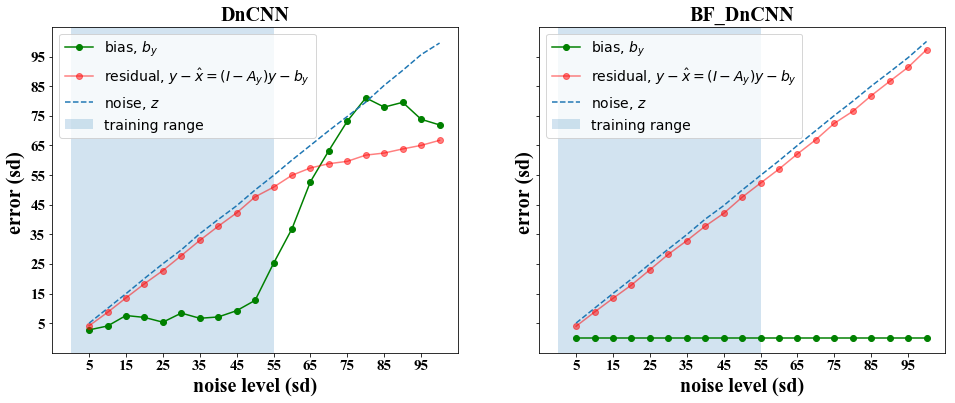

In [8]:
# Choose the training range of the model below. 
low = 0
high = 55

model_folder = ['DnCNN', 'BF_DnCNN']
im_d = 20 # size of the patch used 

f, axs = plt.subplots(1,2, figsize = (16,6), sharey=True)
plt.subplots_adjust()
for i in range(2):
    try: 
        folder_path = 'models/'+model_folder[i]+'/range_'+str(low)+'_'+str(high)+'/results'

        norm_b=np.load(folder_path  + '/norm_b_ave.npy'  )
        norm_res=np.load(folder_path  + '/norm_res_ave.npy'  )
        norm_noise=np.load(folder_path  + '/norm_noise_ave.npy'  )

        axs[i].plot( range(5,105,5),255* norm_b/im_d, 'g-o',label = r'bias, $b_y$', alpha = 1)
        axs[i].plot( range(5,105,5),255* norm_res/im_d, 'r-o',label = r'residual, $y-\hat{x}=(I-A_y)y-b_y$', alpha = .5)
        axs[i].plot( range(5,105,5),255* norm_noise/im_d, '--',label = r'noise, $z$', alpha = 1)

        axs[i].set_xticks(range(5,105,10))
        axs[i].set_yticks(range(5,105,10))

        axs[i].set_xlabel('noise level (sd)',fontsize=20, fontname= 'Times New Roman')
        axs[i].set_ylabel('error (sd) ',fontsize=20, fontname= 'Times New Roman')

        for tick in axs[i].get_xticklabels():
            tick.set_fontsize(15) 
            tick.set_fontname("Times New Roman")

        for tick in axs[i].get_yticklabels():
            tick.set_fontsize(15)
            tick.set_fontname("Times New Roman")

        axs[i].axvspan(low,high, alpha=0.2, label = 'training range');
        axs[i].legend(fontsize = 14);
        
    except FileNotFoundError:         
        print('Results not available for ' + model_folder[i] + ' trained on ' +str(low)+' to '+str(high))

    axs[i].set_title(model_folder[i],fontsize=20, fontname= 'Times New Roman')
        